# Lib

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

from torchvision.datasets import MNIST

# Helper Functions

In [52]:
from sklearn.manifold import TSNE

def get_2d_tsne(x):
    tsne = TSNE(n_components=2)
    x_2d = tsne.fit_transform(x)

    return x_2d

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

# Data

In [6]:
from dataset.customdataset import get_benchmark_dataset

In [7]:
img_size = 32
channels = 1
normal_label = 8
ano_label = 2
num_data = 500

In [8]:
# Datasets
train_normal_ds, _ = get_benchmark_dataset(dataset_name = 'mnist', train = True,
                                                      normal_label = normal_label, ano_label = ano_label,
                                                      num_data = num_data, img_size = img_size, channels = channels,
                                                      data_path = './MNIST', download=False)

test_normal_ds, test_ano_ds = get_benchmark_dataset(dataset_name = 'mnist', train = False,
                                                      normal_label = normal_label, ano_label = ano_label,
                                                      num_data = num_data, img_size = img_size, channels = channels,
                                                      data_path = './MNIST', download=False)

# Gen

In [9]:
from mymodels.generator import Generator_XL, Generator_S

In [40]:
generator = Generator_S(features=64,
                        init_size=8,
                        latent_dim=100,
                        channels=3)
count_parameters(generator)

1051139

In [41]:
# TEST
N,C,H,W = 16, 3, 32, 32
z = torch.FloatTensor(np.random.normal(0, 1, (16, 100)))
generator(z).shape

torch.Size([16, 3, 32, 32])

# UNET

In [11]:
from mymodels.unet import UNet, UNet16

In [12]:
os.environ['TORCH_HOME'] = 'pretrain_models'

In [13]:
unet = UNet()
unet16 = UNet16()

# Train UNET

In [14]:
device = 'cuda'
num_epochs = 100
batch_size = 64

### Data

In [53]:
# Dataloader
train_normal_loader = DataLoader(train_normal_ds, batch_size=batch_size, shuffle=True)
test_normal_loader = DataLoader(test_normal_ds, batch_size=num_data, shuffle=True)
test_ano_loader = DataLoader(test_ano_ds, batch_size=num_data, shuffle=True)

### All in One

In [37]:
unet16 = UNet16(pretrained=True).to(device)
unet = UNet().to(device)
optimizer_UNet = optim.Adam(unet.parameters())
critic = nn.MSELoss()

### Train

In [17]:
loss_min = np.Inf
best_unet = {}

In [18]:
for epoch in range(num_epochs):
    # Training
    unet.train()
    for real_images, _ in train_normal_loader:
        real_images = real_images.repeat(1,3,1,1).to(device)
        optimizer_UNet.zero_grad()
        real_images_hat, _ = unet(real_images)
        loss = critic(unet(real_images), real_images)
        loss.backward()
        optimizer_UNet.step()

    # Eval
    unet.eval()
    for real_images, _ in test_normal_loader:
        real_images = real_images.repeat(1,3,1,1).to(device)
        real_images_hat, _ = unet(real_images)
        loss = critic(real_images_hat, real_images)

    # Save best Model
    loss_Total = loss.item()
    print(f"Epoch{epoch} : Loss = {loss_Total}")
    if loss_Total<loss_min:
        loss_min = loss_Total
        best_unet['epoch'] = epoch
        best_unet['loss'] = loss_Total
        best_unet['unet_parameters'] = unet.state_dict()

KeyboardInterrupt: 

In [ ]:
# best unet
torch.save({'best_unet' : unet.state_dict()}, 'best_unet.pt')

### TSNE on UNET

In [55]:
for x, _ in test_ano_loader:
    x_ano = x
for x, _ in test_normal_loader:
    x_normal = x

In [61]:
device = 'cpu'
unet = unet.to(device)

In [62]:
_, (_,_,_,_, bottleneck_ano) = unet(x_ano.repeat(1,3,1,1))
_, (_,_,_,_, bottleneck_normal) = unet(x_normal.repeat(1,3,1,1))

In [64]:
bottleneck_ano = get_2d_tsne(bottleneck_ano.flatten(1).detach().cpu())
bottleneck_normal = get_2d_tsne(bottleneck_normal.flatten(1).detach().cpu())

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


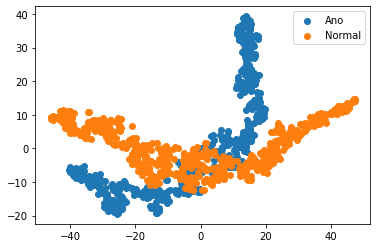

In [66]:
plt.figure()
plt.scatter(bottleneck_ano[:,0], bottleneck_ano[:,1], label = 'Ano')
plt.scatter(bottleneck_normal[:,0], bottleneck_normal[:,1], label = 'Normal')
plt.legend()
plt.show()

# Discri

In [14]:
class Discriminator(nn.Module):
    def __init__(self, unet, out_size_unet):
        super(Discriminator, self).__init__()

        self.unet = unet
        self.change_grad()
        self.fc = nn.Linear(out_size_unet, 1, bias=False)

    def change_grad(self):
        self.unet.requires_grad_(False)
        for i in range(1,5+1): self.unet.get_submodule(f"encoder{i}").requires_grad_(True)

    def forward(self, x):
        _, (_,_,_,_,bottleneck) = self.unet(x)
        out = bottleneck.flatten(1)
        return self.fc(out)

In [15]:
# TEST
N, C, H, W = 16, 3, 32, 32
x = torch.ones(N, C, H, W).to(torch.float).to(device)
_, (_,_,_,_,bottleneck) = unet(x)
discriminator = Discriminator(unet, bottleneck.flatten(1).shape[1]).to(device)
print(bottleneck.flatten(1).shape[1])
print(discriminator(x).shape)
count_parameters(discriminator)

NameError: name 'device' is not defined

# Vanilla GAN

### Hyperparameters

In [26]:
device = 'cpu'
latent_dim = 100
out_size_unet = 2048
batch_size = 10

### Data

In [27]:
# Dataloader
train_normal_loader = DataLoader(train_normal_ds, batch_size=batch_size, shuffle=True)
test_normal_loader = DataLoader(test_normal_ds, batch_size=num_data, shuffle=True)
#test_ano_loader = DataLoader(test_ano_ds, batch_size=num_data, shuffle=True)

### All in One

In [42]:
# Nets
generator = Generator_S(features=64,
                        init_size=8,
                        latent_dim=latent_dim,
                        channels=3).to(device)

discriminator = Discriminator(unet, out_size_unet).to(device)

In [43]:
# Loss & Optimizers
adversarial_loss = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

### Re-Init

In [44]:
# WRONG
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [45]:
generator = generator.apply(weights_init_normal)
discriminator = discriminator.apply(weights_init_normal)

### Train

In [46]:
#save_tsne = {}
total_G_loss = 0.0
total_D_loss = 0.0

In [47]:
device = 'cuda'

init_epoch = 1
num_epochs = 1000
sample_interval = 1

In [48]:
"""
root_bp = "./results/vanilla_gan_research/last_parameters.pt"

info = torch.load(root_bp)
init_epoch = info['epoch']
generator.load_state_dict(info['state_dict_G'])
discriminator.load_state_dict(info['state_dict_D'])
optimizer_G.load_state_dict(info['optimizer_G'])
optimizer_D.load_state_dict(info['optimizer_D'])
save_tsne = info['save_tsne']
"""

'\nroot_bp = "./results/vanilla_gan_research/last_parameters.pt"\n\ninfo = torch.load(root_bp)\ninit_epoch = info[\'epoch\']\ngenerator.load_state_dict(info[\'state_dict_G\'])\ndiscriminator.load_state_dict(info[\'state_dict_D\'])\noptimizer_G.load_state_dict(info[\'optimizer_G\'])\noptimizer_D.load_state_dict(info[\'optimizer_D\'])\nsave_tsne = info[\'save_tsne\']\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


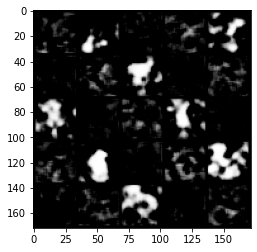

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


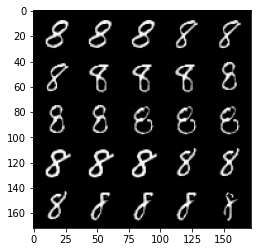

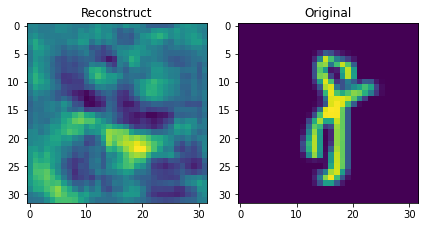

KeyboardInterrupt: 

In [50]:
torch.cuda.empty_cache()
for epoch in range(init_epoch, num_epochs+1):
    torch.cuda.empty_cache()
    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_normal_loader):
        torch.cuda.empty_cache()
        # Preprocessing ##############################################
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        real_images = real_images.repeat(1,3,1,1).to(device)
        generator = generator.to(device)
        discriminator = discriminator.to(device)

        # Train Generator ########################################
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)

        g_loss_adv = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss = g_loss_adv
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()


        # Train Discriminator ########################################
        optimizer_D.zero_grad()
        discriminator_opinion_real = discriminator(real_images)
        discriminator_opinion_fake = discriminator(gen_imgs.detach())
        real_loss = adversarial_loss(discriminator_opinion_real, valid)
        fake_loss = adversarial_loss(discriminator_opinion_fake, fake)
        d_loss_adv = (real_loss + fake_loss) / 2
        d_loss = d_loss_adv

        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()


    # Load Test Data ##############################################
    torch.cuda.empty_cache()
    if epoch%sample_interval==0 or epoch==1:
      # Visualization ##############################################
      show_tensor_images(gen_imgs, size=(channels, img_size, img_size))
      show_tensor_images(real_images, size=(channels, img_size, img_size))

      num = math.floor(np.random.uniform(0, len(real_images)))
      ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])


      torch.save({"epoch": epoch,
      "state_dict_G": generator.state_dict(),
      "state_dict_D": discriminator.state_dict(),
      "optimizer_G": optimizer_G.state_dict(),
      "optimizer_D": optimizer_D.state_dict(),
      }, f"./save_pts/vanillagan_epoch_{epoch}.pt")

# WGAN